In [1]:
import requests
import json
import numpy as np
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot as plt
import numpy

/home/yujiaze/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/yujiaze/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/yujiaze/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/yujiaze/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/yujiaze/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.

ImportError: Traceback (most recent call last):
  File "/home/yujiaze/anaconda3/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/home/yujiaze/anaconda3/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/home/yujiaze/anaconda3/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/home/yujiaze/anaconda3/lib/python3.6/imp.py", line 243, in load_module
    return load_dynamic(name, filename, file)
  File "/home/yujiaze/anaconda3/lib/python3.6/imp.py", line 343, in load_dynamic
    return _load(spec)
ImportError: /home/yujiaze/anaconda3/lib/python3.6/site-packages/tensorflow/python/../libtensorflow_framework.so: undefined symbol: cuDevicePrimaryCtxGetState


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/install_sources#common_installation_problems

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

# Single-step prediction
This baseline SNMP traffic prediction model produces one-step forecasting using LSTM. Following the ARIMA (Autoregressive Integrated Moving Average) paradigm for time series analysis, it first transforms the SNMP traffic data into a stationary data by differencing the data at each time step such that the model can learn the fluctuations of the traffic data better 

In [2]:
e1, e2 = "", ""
def run_query(query): # A simple function to use requests to make the API call.
   request = requests.get('https://my.es.net/graphql', json={'query': query})
   if request.status_code == 200:
       return request.json()
   else:
       raise Exception("Query failed to run by returning code of {}. {}".format(request.status_code, query))
    
def getData(id, beginTime, endTime):
    global e1, e2
    query = '''
    {
      mapTopologyEdge(id: "%d") {
            name
        traffic(beginTime: "%s", endTime: "%s") {
          columns
          name
          points
          utc
          labels
          interface
          device
          sap
          tile
        }
      }
    }
    ''' % (id, beginTime, endTime)
    data = run_query(query)
    print(data)
    datastr = data["data"]["mapTopologyEdge"]["traffic"]
    e1, e2 = datastr["labels"]
    composite = np.array(datastr["points"])
    return {'time':composite[:, 0], e1:composite[:, 1], e2:composite[:,2]}

In [3]:
cleaned_data = getData(1894, "2018-05-20T18:22:53.253Z", "2018-05-21T19:22:53.253Z")

{'data': {'mapTopologyEdge': {'name': 'DENV--PNWG', 'traffic': {'columns': ['time', 'atoz', 'ztoa'], 'name': '', 'points': [[1526774400000.0, 690204436.7139785, 1044761427.0107524], [1526774430000.0, 876701155.1882436, 1244295779.353692], [1526774460000.0, 920300964.5320638, 925131575.791746], [1526774490000.0, 814008931.8704758, 823680777.615238], [1526774520000.0, 1434407358.9307938, 886762730.9307938], [1526774550000.0, 835341799.146667, 855557768.4977779], [1526774580000.0, 654250657.7422216, 679783311.0400004], [1526774610000.0, 968129982.112115, 593366712.3234406], [1526774640000.0, 2324527449.2717743, 1063229874.9532256], [1526774670000.0, 3820006329.753889, 761695557.461111], [1526774700000.0, 2628015176.684445, 548507802.8266667], [1526774730000.0, 3160909173.8382797, 2270333642.0063076], [1526774760000.0, 2053731220.0111318, 2213778517.585326], [1526774790000.0, 1645284677.981699, 1485085679.581699], [1526774820000.0, 1494206253.0722225, 1305336036.8055556], [1526774850000.0,

In [4]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

In [5]:
# transform data to be stationary
raw_values = cleaned_data[e1]
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train_size = int(len(supervised_values) * 0.67)
test_size = len(supervised_values) - train_size
train, test = supervised_values[0:train_size,:], supervised_values[train_size:len(supervised_values),:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [6]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 30, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Timestep=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Epoch 1/1
3858/3858 [==============================] - 5s 1ms/step - loss: 0.0119
Epoch 1/1
3858/3858 [==============================] - 4s 1ms/step - loss: 0.0114
Epoch 1/1
3858/3858 [==============================] - 4s 1ms/step - loss: 0.0112
Epoch 1/1
3858/3858 [==============================] - 6s 2ms/step - loss: 0.0111
Epoch 1/1
3858/3858 [==============================] - 5s 1ms/step - loss: 0.0112
Epoch 1/1
3858/3858 [==============================] - 5s 1ms/step - loss: 0.0112
Epoch 1/1
3858/3858 [==============================] - 5s 1ms/step - loss: 0.0111
Epoch 1/1
3858/3858 [==============================] - 5s 1ms/step - loss: 0.0111
Epoch 1/1
3858/3858 [==============================] - 5s 1ms/step - loss: 0.0111
Epoch 1/1
3858/3858 [==============================] - 5s 1ms/step - loss: 0.0110
Epoch 1/1
3858/3858 [==============================] - 7s 2ms/step - loss: 0.0111
Epoch 1/1
3858/3858 [==============================] - 5s 1ms/step - loss: 0.0111
Epoch 1/1
3858/3

Timestep=393, Predicted=495487951.842505, Expected=504520373.728736
Timestep=394, Predicted=672817461.287474, Expected=450927683.535781
Timestep=395, Predicted=586878743.974536, Expected=971326137.259928
Timestep=396, Predicted=1065083322.383774, Expected=754689626.124445
Timestep=397, Predicted=800112134.578173, Expected=281008799.781218
Timestep=398, Predicted=366969379.979453, Expected=716809583.676559
Timestep=399, Predicted=833347236.751274, Expected=1274162581.734193
Timestep=400, Predicted=1288270080.461794, Expected=1382926534.825807
Timestep=401, Predicted=1348444848.003848, Expected=1243759191.466667
Timestep=402, Predicted=1233612538.901801, Expected=945491227.066666
Timestep=403, Predicted=990787229.007691, Expected=684801780.888889
Timestep=404, Predicted=794433396.422602, Expected=572866323.308961
Timestep=405, Predicted=732825627.321446, Expected=475252218.408602
Timestep=406, Predicted=658855632.383928, Expected=1120830538.116130
Timestep=407, Predicted=1282283986.61648

Timestep=792, Predicted=1202778132.995543, Expected=1935314089.927742
Timestep=793, Predicted=1964807889.839464, Expected=4224671150.467957
Timestep=794, Predicted=3327737243.287379, Expected=3346869191.745376
Timestep=795, Predicted=2653685562.718088, Expected=3215520644.418065
Timestep=796, Predicted=2645892421.775299, Expected=3411773105.548387
Timestep=797, Predicted=2900891131.048555, Expected=4665676734.593548
Timestep=798, Predicted=3803428370.244220, Expected=10618809657.840000
Timestep=799, Predicted=4052500273.956210, Expected=5630044115.039999
Timestep=800, Predicted=5583323671.041061, Expected=7721955978.178064
Timestep=801, Predicted=6941111456.198207, Expected=2247427090.826381
Timestep=802, Predicted=2156158831.494497, Expected=2066339165.199427
Timestep=803, Predicted=2365624664.690995, Expected=1222908491.716129
Timestep=804, Predicted=1419989443.703127, Expected=963428123.733333
Timestep=805, Predicted=1314577340.104531, Expected=809832146.133333
Timestep=806, Predict

Timestep=1178, Predicted=3006998410.201381, Expected=2777188247.217206
Timestep=1179, Predicted=2798902484.254647, Expected=2799892723.701791
Timestep=1180, Predicted=2822463337.174463, Expected=2945826670.027240
Timestep=1181, Predicted=2936487938.911531, Expected=2998189194.710538
Timestep=1182, Predicted=2953261692.043027, Expected=2744818382.485161
Timestep=1183, Predicted=2697507663.799208, Expected=1535126903.741936
Timestep=1184, Predicted=1472463273.470864, Expected=1200513839.977348
Timestep=1185, Predicted=1310936655.449037, Expected=1020433757.863513
Timestep=1186, Predicted=1162544424.679636, Expected=1334166218.038709
Timestep=1187, Predicted=1489032673.294455, Expected=3010602768.275269
Timestep=1188, Predicted=2791973489.622890, Expected=3288297982.133334
Timestep=1189, Predicted=2906792209.456388, Expected=1464315381.022508
Timestep=1190, Predicted=1184709108.473640, Expected=1631938437.996846
Timestep=1191, Predicted=1563625073.881023, Expected=1344996554.705377
Timest

Timestep=1530, Predicted=3528681438.079732, Expected=3230433245.900000
Timestep=1531, Predicted=2460051902.357176, Expected=3855936695.760000
Timestep=1532, Predicted=3055262064.220544, Expected=6272243335.801291
Timestep=1533, Predicted=4347230746.863635, Expected=4018914901.967598
Timestep=1534, Predicted=3539255888.747361, Expected=1292225500.004445
Timestep=1535, Predicted=987010794.027545, Expected=1340857686.374713
Timestep=1536, Predicted=1441009433.806193, Expected=908045162.438620
Timestep=1537, Predicted=978325239.017999, Expected=982522937.377778
Timestep=1538, Predicted=1174539248.141274, Expected=1324921332.559426
Timestep=1539, Predicted=1504047975.947139, Expected=1681677500.318280
Timestep=1540, Predicted=1812667026.615255, Expected=1639597015.139516
Timestep=1541, Predicted=1708696969.731730, Expected=1093487166.898333
Timestep=1542, Predicted=1131070545.433159, Expected=1685266920.133333
Timestep=1543, Predicted=1763594370.882676, Expected=1650309217.013333
Timestep=1

Test RMSE: 1380061066.355


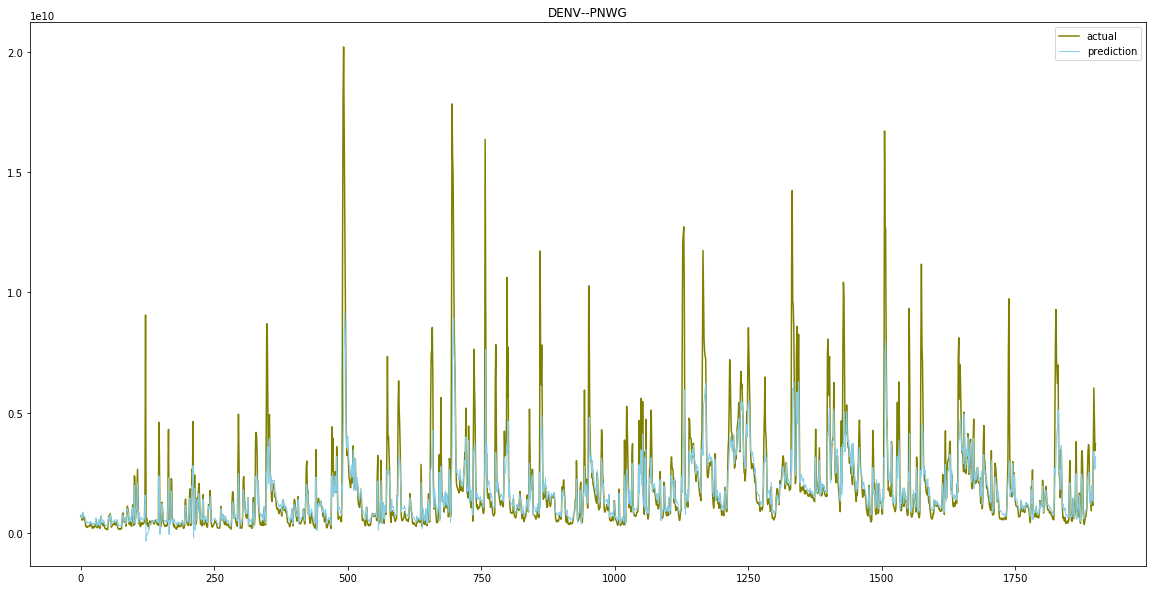

In [7]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[train_size:len(supervised_values)], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
plt.figure(figsize=(20,10))
plt.plot(raw_values[train_size:len(supervised_values)], color='olive', linewidth=1.5, label='actual')
plt.plot(predictions, color='skyblue', linewidth=1, label='prediction')
plt.legend()
plt.title(e1)
plt.show()

In [8]:
# transform data to be stationary
raw_values = cleaned_data[e2]
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train_size = int(len(supervised_values) * 0.67)
test_size = len(supervised_values) - train_size
train, test = supervised_values[0:train_size,:], supervised_values[train_size:len(supervised_values),:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 60, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Timestep=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Epoch 1/1
3858/3858 [==============================] - 13s 3ms/step - loss: 0.0301
Epoch 1/1
3858/3858 [==============================] - 14s 4ms/step - loss: 0.0279
Epoch 1/1
3858/3858 [==============================] - 12s 3ms/step - loss: 0.0275
Epoch 1/1
3858/3858 [==============================] - 13s 3ms/step - loss: 0.0281
Epoch 1/1
3858/3858 [==============================] - 13s 3ms/step - loss: 0.0269
Epoch 1/1
3858/3858 [==============================] - 14s 4ms/step - loss: 0.0290
Epoch 1/1
3858/3858 [==============================] - 16s 4ms/step - loss: 0.0262
Epoch 1/1
3858/3858 [==============================] - 12s 3ms/step - loss: 0.0263
Epoch 1/1
3858/3858 [==============================] - 12s 3ms/step - loss: 0.0263
Epoch 1/1
3858/3858 [==============================] - 14s 4ms/step - loss: 0.0261
Epoch 1/1
3858/3858 [==============================] - 15s 4ms/step - loss: 0.0260
Epoch 1/1
3858/3858 [==============================] - 13s 3ms/step - loss: 0.0260
Epoc

Timestep=178, Predicted=1129220737.711643, Expected=410963375.664516
Timestep=179, Predicted=703073193.251708, Expected=865500742.004301
Timestep=180, Predicted=1272908652.906606, Expected=423904817.445161
Timestep=181, Predicted=723618837.963490, Expected=400569931.173620
Timestep=182, Predicted=756880954.118114, Expected=542204558.317778
Timestep=183, Predicted=939178023.262792, Expected=465824170.393333
Timestep=184, Predicted=834869737.471623, Expected=1328600852.480000
Timestep=185, Predicted=1692549281.582122, Expected=2478684026.560000
Timestep=186, Predicted=2548174732.681604, Expected=1093464222.744086
Timestep=187, Predicted=956960562.227089, Expected=679868672.954839
Timestep=188, Predicted=780534884.526324, Expected=498554364.163441
Timestep=189, Predicted=745130826.423777, Expected=420885303.647311
Timestep=190, Predicted=746733805.092124, Expected=407313170.001434
Timestep=191, Predicted=774978146.922197, Expected=516951933.155556
Timestep=192, Predicted=911985001.544393,

Timestep=341, Predicted=935486636.761846, Expected=419421420.000000
Timestep=342, Predicted=764661601.812778, Expected=481937500.146237
Timestep=343, Predicted=859679656.307240, Expected=807756186.145430
Timestep=344, Predicted=1209067320.599324, Expected=692981448.366398
Timestep=345, Predicted=1033059967.266193, Expected=523814189.768602
Timestep=346, Predicted=855894604.793648, Expected=638376282.026667
Timestep=347, Predicted=1015890110.666829, Expected=498254472.408889
Timestep=348, Predicted=850988401.086008, Expected=396457497.464660
Timestep=349, Predicted=757235682.501351, Expected=1406628143.156451
Timestep=350, Predicted=1748988498.458180, Expected=2730352720.834946
Timestep=351, Predicted=2643268853.305664, Expected=2143090099.059499
Timestep=352, Predicted=1988758962.174562, Expected=1578616627.466666
Timestep=353, Predicted=1602701478.651142, Expected=2256844165.327599
Timestep=354, Predicted=2386872211.440565, Expected=1176244745.987957
Timestep=355, Predicted=1191625924

Timestep=516, Predicted=3330545905.248039, Expected=550262084.270107
Timestep=517, Predicted=-103659850.538752, Expected=1028068986.360000
Timestep=518, Predicted=1057979232.955028, Expected=929661266.155556
Timestep=519, Predicted=1072518153.565553, Expected=1725015332.426666
Timestep=520, Predicted=2066609578.615809, Expected=985516786.062222
Timestep=521, Predicted=1162540678.951583, Expected=731408045.439427
Timestep=522, Predicted=1026695190.447034, Expected=842927403.286021
Timestep=523, Predicted=1242093277.276284, Expected=2254365024.596228
Timestep=524, Predicted=2497198155.101886, Expected=2660512249.425137
Timestep=525, Predicted=2710071944.103128, Expected=2608585791.644299
Timestep=526, Predicted=2678183080.122941, Expected=1106847458.239713
Timestep=527, Predicted=1051782458.113201, Expected=1226587083.458065
Timestep=528, Predicted=1455201374.928326, Expected=643382909.066667
Timestep=529, Predicted=874691088.979623, Expected=1452056366.650000
Timestep=530, Predicted=179

Timestep=681, Predicted=2896710001.596481, Expected=3279002783.012473
Timestep=682, Predicted=3135832910.712732, Expected=2976012255.867527
Timestep=683, Predicted=3066539087.487810, Expected=1762911837.827097
Timestep=684, Predicted=1902605896.558913, Expected=1391306297.840860
Timestep=685, Predicted=1772848452.596421, Expected=2430752093.926882
Timestep=686, Predicted=3060423067.029362, Expected=4172866874.245161
Timestep=687, Predicted=4320128833.713816, Expected=5119872724.318280
Timestep=688, Predicted=4770732723.735278, Expected=4711534052.890609
Timestep=689, Predicted=4473833377.317272, Expected=7454637942.102939
Timestep=690, Predicted=5887055740.566141, Expected=5928921167.754839
Timestep=691, Predicted=5029562753.557853, Expected=2219997557.363441
Timestep=692, Predicted=1932008824.429632, Expected=1910435489.285448
Timestep=693, Predicted=2186041864.499768, Expected=1735144023.937778
Timestep=694, Predicted=2321107929.847868, Expected=1352407055.895054
Timestep=695, Predic

Timestep=840, Predicted=1428648507.196427, Expected=863561077.649032
Timestep=841, Predicted=1408344681.902754, Expected=875071719.624086
Timestep=842, Predicted=1387784880.796553, Expected=969368458.701075
Timestep=843, Predicted=1466349599.129496, Expected=1102078963.174193
Timestep=844, Predicted=1577046143.083753, Expected=1291991081.513979
Timestep=845, Predicted=1747012197.850583, Expected=1025770555.466667
Timestep=846, Predicted=1391478312.863164, Expected=1012275197.120000
Timestep=847, Predicted=1401977044.785903, Expected=1282660532.686452
Timestep=848, Predicted=1705895093.528306, Expected=1330339974.726881
Timestep=849, Predicted=1714487918.697513, Expected=1015297798.166667
Timestep=850, Predicted=1339826692.713277, Expected=880751855.717778
Timestep=851, Predicted=1235569840.244361, Expected=845012590.346666
Timestep=852, Predicted=1228145511.683446, Expected=921499579.459211
Timestep=853, Predicted=1322470712.873830, Expected=1139312953.189678
Timestep=854, Predicted=15

Timestep=1012, Predicted=2398094281.073175, Expected=1858958800.195556
Timestep=1013, Predicted=2252651454.330922, Expected=1633556678.781111
Timestep=1014, Predicted=1998709056.875823, Expected=1702947106.943334
Timestep=1015, Predicted=2144050094.799134, Expected=2050532358.026667
Timestep=1016, Predicted=2569914276.562576, Expected=2520450078.054193
Timestep=1017, Predicted=3075767516.589838, Expected=3352419107.181363
Timestep=1018, Predicted=3979166757.546090, Expected=2782298785.076702
Timestep=1019, Predicted=3063105670.979001, Expected=4687763069.006452
Timestep=1020, Predicted=5530214262.823069, Expected=2975191753.321290
Timestep=1021, Predicted=2951111561.447175, Expected=5846977052.657205
Timestep=1022, Predicted=6969651635.579914, Expected=6820650134.640861
Timestep=1023, Predicted=7511713652.171708, Expected=3743183694.993548
Timestep=1024, Predicted=3413707087.848635, Expected=2036599083.575054
Timestep=1025, Predicted=1957388475.788912, Expected=1962071237.653333
Timest

Timestep=1187, Predicted=1951755119.734770, Expected=2670084437.126881
Timestep=1188, Predicted=3249996833.654011, Expected=2971689642.597850
Timestep=1189, Predicted=3448056891.891144, Expected=7859437428.150826
Timestep=1190, Predicted=9855216860.867680, Expected=10147191602.748100
Timestep=1191, Predicted=11470011803.962891, Expected=10983273504.389677
Timestep=1192, Predicted=11794308801.396614, Expected=6163030316.092043
Timestep=1193, Predicted=5869768246.726817, Expected=6541284651.351190
Timestep=1194, Predicted=7024983394.408701, Expected=6439457723.248485
Timestep=1195, Predicted=6849664002.079514, Expected=7840110980.383839
Timestep=1196, Predicted=8580448086.028415, Expected=6084084417.946667
Timestep=1197, Predicted=6050177731.192324, Expected=6944141990.364445
Timestep=1198, Predicted=7511120402.043985, Expected=7262508891.561291
Timestep=1199, Predicted=7734226803.726370, Expected=7253157680.065375
Timestep=1200, Predicted=7654030199.897313, Expected=6228524011.890000
Ti

Timestep=1349, Predicted=5520322444.871777, Expected=6709913357.771469
Timestep=1350, Predicted=7454786356.187080, Expected=9593437655.588530
Timestep=1351, Predicted=10638250561.710709, Expected=6819503693.899642
Timestep=1352, Predicted=6489302149.642993, Expected=5608465998.695915
Timestep=1353, Predicted=5615882719.504121, Expected=7967446821.252473
Timestep=1354, Predicted=8911278533.290508, Expected=7201203691.057527
Timestep=1355, Predicted=7448184679.293953, Expected=4697434235.308065
Timestep=1356, Predicted=4469377768.901517, Expected=3779477099.830824
Timestep=1357, Predicted=3907061720.506263, Expected=3964936814.755556
Timestep=1358, Predicted=4374931367.678988, Expected=4621801477.232975
Timestep=1359, Predicted=5140850478.084595, Expected=5342777772.784803
Timestep=1360, Predicted=5870809242.499230, Expected=6715039901.704444
Timestep=1361, Predicted=7365209772.100967, Expected=5189093919.833333
Timestep=1362, Predicted=5143791996.424450, Expected=3515541891.688889
Times

Timestep=1501, Predicted=2921186787.913764, Expected=2618519810.208458
Timestep=1502, Predicted=3050504417.327678, Expected=2610634330.684444
Timestep=1503, Predicted=3046132392.553597, Expected=3553222029.601721
Timestep=1504, Predicted=4195215716.152077, Expected=4615175356.762724
Timestep=1505, Predicted=5258613715.697736, Expected=4265211532.398567
Timestep=1506, Predicted=4564640115.846488, Expected=3529099928.464516
Timestep=1507, Predicted=3726058042.442717, Expected=2832607036.862589
Timestep=1508, Predicted=3039232823.620966, Expected=2906186130.696552
Timestep=1509, Predicted=3313827238.926251, Expected=3261195052.786667
Timestep=1510, Predicted=3756055724.493904, Expected=2844777562.415484
Timestep=1511, Predicted=3160688448.848743, Expected=2719967864.094624
Timestep=1512, Predicted=3102717066.810580, Expected=2822705832.103226
Timestep=1513, Predicted=3270757591.199215, Expected=2963194891.644444
Timestep=1514, Predicted=3430860682.048472, Expected=2222804980.106093
Timest

Timestep=1663, Predicted=1103492269.781495, Expected=3571607488.622223
Timestep=1664, Predicted=3028561752.101730, Expected=3541427025.262222
Timestep=1665, Predicted=3109397826.000733, Expected=1452309167.702939
Timestep=1666, Predicted=1263900674.050166, Expected=2667540194.984947
Timestep=1667, Predicted=2963747954.785748, Expected=2804425311.818781
Timestep=1668, Predicted=3168753917.864234, Expected=1446159131.662222
Timestep=1669, Predicted=1557563045.326289, Expected=1427448895.426523
Timestep=1670, Predicted=1800076205.223898, Expected=1197558103.489033
Timestep=1671, Predicted=1597096739.035376, Expected=1206173097.052903
Timestep=1672, Predicted=1649046702.300086, Expected=1201730875.953763
Timestep=1673, Predicted=1642768342.775953, Expected=2493329595.011112
Timestep=1674, Predicted=2890193489.308703, Expected=4139489158.844444
Timestep=1675, Predicted=3866526878.091733, Expected=1674530500.496058
Timestep=1676, Predicted=1229490948.966049, Expected=1474581885.015054
Timest

Timestep=1823, Predicted=2549663389.737550, Expected=551728448.012903
Timestep=1824, Predicted=452026358.319968, Expected=621738799.273118
Timestep=1825, Predicted=793379342.373953, Expected=706377016.966882
Timestep=1826, Predicted=980869423.932405, Expected=703314458.506667
Timestep=1827, Predicted=1002762963.890483, Expected=1034389347.554409
Timestep=1828, Predicted=1376602280.530515, Expected=1729481235.165591
Timestep=1829, Predicted=2026329927.915105, Expected=2252192076.750000
Timestep=1830, Predicted=2444873393.801223, Expected=4454647169.632796
Timestep=1831, Predicted=3583561524.148362, Expected=928158079.074982
Timestep=1832, Predicted=290114369.884155, Expected=482010624.746667
Timestep=1833, Predicted=518301978.086298, Expected=475898008.771900
Timestep=1834, Predicted=769988730.851589, Expected=453613649.601433
Timestep=1835, Predicted=908321770.189642, Expected=655042665.306093
Timestep=1836, Predicted=1169403038.544816, Expected=1094909513.582796
Timestep=1837, Predict

Test RMSE: 617689752.748


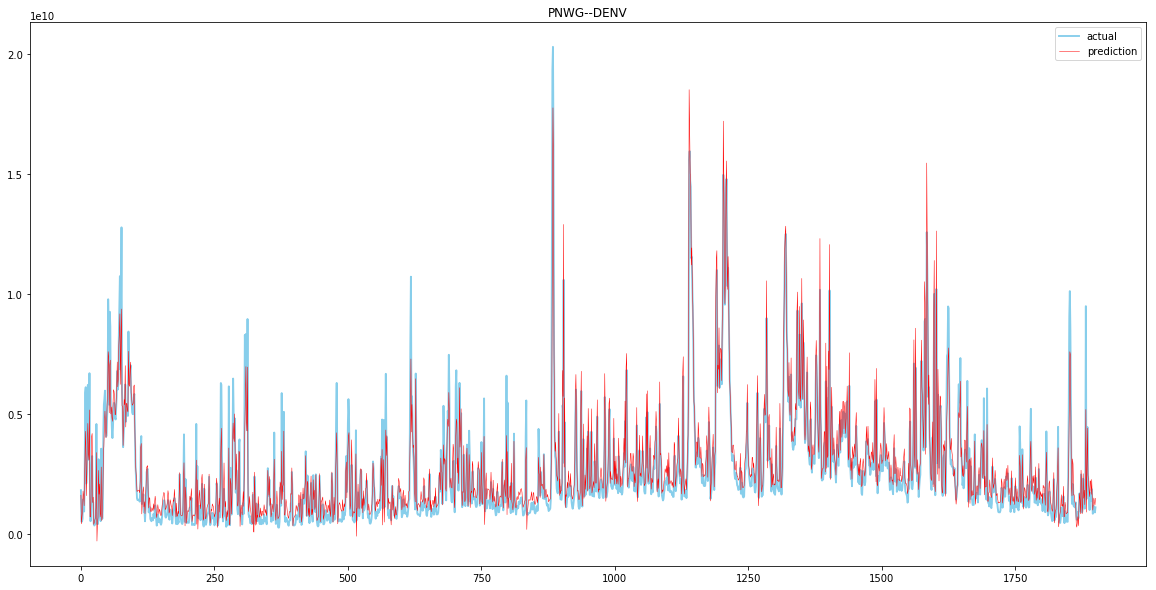

In [15]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[train_size:len(supervised_values)], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
plt.figure(figsize=(20,10))
plt.plot(raw_values[train_size:len(supervised_values)], color='skyblue', linewidth=1.9, label='actual')
plt.plot(predictions, color='red', linewidth=0.5, label='prediction')
plt.legend()
plt.title(e2)
plt.show()

<Figure size 432x288 with 0 Axes>

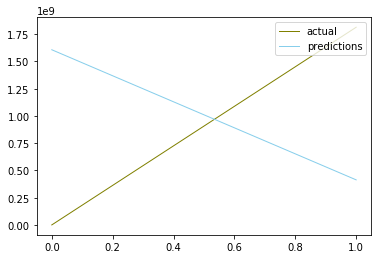

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

KeyboardInterrupt: 

In [18]:
import time
%matplotlib inline
def plot_stream(y1, y2, e1, e2):    
    xdata = []
    ydata1 = []
    ydata2 = []
    
    plt.figure()
    plt.show()

    axes = plt.gca()
    line1, = axes.plot(ydata1, 'olive', linewidth=1)
    line2, = axes.plot(ydata2, 'skyblue', linewidth=1)
    line1.set_label(e1)
    line2.set_label(e2)
    axes.legend(loc=1)

    xdata.append(0)
    ydata1.append(0)
    ydata2.append(y2[0])
    
    for i in range(len(y1)):
        if len(ydata1) == 100:
            del xdata[0]
            del ydata1[0]
            del ydata2[0]
        xdata.append(i+1)
        ydata1.append(y1[i])
        ydata2.append(y2[i+1])
        line1.set_xdata(xdata)
        line1.set_ydata(ydata1)

        line2.set_xdata(xdata)
        line2.set_ydata(ydata2)
        axes.relim()
        axes.autoscale_view()
        plt.draw()
        plt.pause(1e-17)
        time.sleep(0.1)

    # add this if you don't want the window to disappear at the end
    plt.show()
plot_stream(raw_values[train_size:len(supervised_values)], predictions, 'actual', 'predictions')